# Validation of Bayesian Parameter Inference Implementation using Ideal Diode Example from MIT PV-lab

In this notebook, I show my implementation of Bayesian parameter inference and validate the results using this benchmark code from MIT’s PV-lab: https://github.com/PV-Lab/bayesim/blob/master/examples/diode/ideal_diode.ipynb. 

In summary, we will use Bayesian inference to fit two solar cell parameters $B$ and $n$ to the ideal-diode model, which describes the current density $J$ as a function of voltage $V$ and temperature $T$: 

$$ J(V,T)= J_L + J_0(exp\frac{qV}{nKT}-1) $$

where $K = 8.617333*10^{-5} eV/K$ is Boltzmann's constant, $J_L=-0.3 mA/cm^2$ is the light current (negative by convention, treated as fixed here), and $J_0$ is the saturation current (positive by convention), which can be approximated as:

$$ J_0 = BT^{3/n}exp\frac{-E_{g0}}{nKT} $$

where $E_{g0}=1.2 eV$ is the silicon zero-temperature bandgap.

Please refer to the MIT PV-lab notebook to get a better understanding of this model and familiarize yourself with the case study at hand.

Some features are still missing from this work in progress, but I just wanted to demonstrate a draft version that comes with a small twist and yields (almost) the exact same results in a fraction of the time.

## Import the libraries needed

In [ ]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib

## Define the fitting parameters of the ideal diode model

In [ ]:
params = ['Bp', 'n']
labels = ['B', 'n']
units = ['mA*K$^{-3/n}$/cm$^2$', 'unitless']
param_ranges = [np.logspace(1, 3, 20), np.linspace(1, 2, 20)]

nb_params = len(params)

param_combs = list(itertools.product(*param_ranges)) #get all the possible parameter combinations (i.e. all possible hypotheses)

## Get and plot the "observed" data

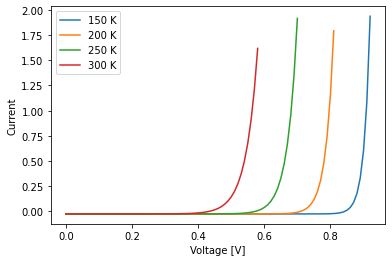

In [ ]:
def compute_ID(ec, param_comb): #same function used in the MIT notebook
    J_L = -0.03 
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T 
    n = param_comb[1]
    Bp = param_comb[0]
    J0 = Bp*T**(3/n)*np.exp(-1.2/V_th/n)
    return J_L + J0*(np.exp(V/V_th/n)-1)

V = np.arange(0, 1.0, 0.01)
T = [float(t) for t in np.arange(150, 301, 50)]

true_comb = [258, 1.36]

data = []
for t in T:
    J = [compute_ID({'V':v,'T':t}, true_comb) for v in V]
    J = [j for j in J if not j > 2.0]
    data.append([V[:len(J)], t, J])

data = pd.DataFrame(data, columns=['V', 'T', 'J']) #ignore uncertainty factor for now

fig, ax = plt.subplots()
for idx in data.index:
    ax.plot(data.loc[idx, 'V'], data.loc[idx, 'J'], label=f"{int(data.loc[idx, 'T'])} K")
plt.legend()
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

The same data DataFrame was generated. The only difference is that the voltage is not considered an experimental condition here. Therefore, we went from having 305 elements in the DataFrame to just 4 (one for each temperature).

In [ ]:
def compute_ID_og(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*np.exp(-1.2/V_th/n)
    return J_L + J0*(np.exp(V/V_th/n)-1)

# define the vectors of experimental conditions
V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]

# set the "true" values for the parameters
true_params = {'n':1.36,'Bp':258}

# generate the "observations"
data_og = []
for t in T:
    # J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID_og({'V':v,'T':t},true_params)
        # if abs(J)>0.1: #ignore for now
        #     err = 0.05*abs(J)
        # else:
        #     err = 0.005
        # # check for "compliance"
        if not J > 2.0:
            data_og.append([v,t,J])
          
data_og = pd.DataFrame(data_og, columns=['V', 'T', 'J']) #ignore uncertainty factor for now

print('Original format')
print(data_og.head())

print()

print('New format')
data.head()

Original format
      V      T     J
0  0.00  150.0 -0.03
1  0.01  150.0 -0.03
2  0.02  150.0 -0.03
3  0.03  150.0 -0.03
4  0.04  150.0 -0.03

New format


,V,T,J
0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",150.0,"[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0...."
1,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",200.0,"[-0.03, -0.029999999999999045, -0.029999999999..."
2,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",250.0,"[-0.03, -0.02999999996664946, -0.0299999999197..."
3,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",300.0,"[-0.03, -0.02999996283217354, -0.0299999134362..."


Note that we still have 305 data points, it's just that in this case, they are reduced to 4 rows, where each row consists of a full JV curve (embedded in a list) at each of the 4 operating temperatures. This makes a great difference in the computation time, especially when you have more opretating temperatures (or conditions such as irradiance) and more voltage points for curve.

In [ ]:
nb_pts = 0
for i in range(len(data)):
  nb_pts += len(data.loc[i, 'V'])

print(nb_pts)

305


## Run Bayesian inference

We can use Bayes' Theorem to fit parameters $\theta$ on some observed data $d$ as follows:

$$P(\theta|d) = \frac{P(\theta) P(d|\theta)}{P(d)} $$

Here, the likelihood is assumed to follow an exponential distribution and can be calculated using the Mean Squared Error (MSE) between the observed current density $J_{obs}$ and the modeled current $J_{modeled}$  (at every observed voltage point and temperature) for each possible parameter combination of _B_ and _n_ (hypothesis $\theta$). 

$$P(d|\theta) = P(J| (B,n)) = e^{-∑(J_{obs}-J_{modeled})^2} $$

In [ ]:
bpe = pd.DataFrame(index=pd.MultiIndex.from_tuples(param_combs, names=params)) #BPE: Bayesian Parameter Estimation

bpe['Prior'] = 1/len(param_combs) #assume that all the parameter combinations are equiprobable
bpe['Error'] = np.nan

for param_comb in param_combs:
  err = []
  
  # Calculate the error between the observed and modeled currents at every voltage point and temperature
  for i in range(len(data)): 
    T = data.loc[i, 'T']
    j_obs = data.loc[i, 'J']

    j_model = [compute_ID({'V':v,'T':T}, param_comb) for v in data.loc[i, 'V']]

    err.append(mse(j_model, j_obs))

    bpe.loc[param_comb, 'Error'] = np.sum(err)

bpe['Likelihood'] = np.exp(-bpe['Error'])

bpe['Posterior'] = bpe['Prior']*bpe['Likelihood']/np.sum(bpe['Prior']*bpe['Likelihood'])

In [ ]:
top_fits = bpe.sort_values(by=['Error'], ascending=True).head(10)

print('Best fits:')
top_fits[['Error', 'Posterior']]

Best fits:


,,Error,Posterior
Bp,n,,
297.635144,1.315789,0.000485,0.003731
379.269019,1.263158,0.000574,0.003730
143.844989,1.526316,0.001147,0.003728
483.293024,1.210526,0.001289,0.003728
233.572147,1.368421,0.001457,0.003727
183.298071,1.473684,0.002271,0.003724
615.848211,1.157895,0.002795,0.003722
183.298071,1.421053,0.004198,0.003717
112.883789,1.578947,0.004250,0.003717


In [ ]:
print(bpe['Posterior'].sum())

1.0


### **Remark**

Note that the true parameter combination (B = 258 & n = 1.36) is not found because the value B = 258 is not sampled in the parameter space. Since this code runs fast, we can simply increase the number of points in the parameter space (or adjust it without increasing the total number of points) and re-run the whole thing.

Moreover, this approach will yield slightly different results (see below) because the parmater range of B taken here (np.logspace(1, 3, 20)) is not exactly the same as the one taken in the benchmark notebook ([11.22, 14.125, 17.783, 22.387, 28.184, 35.481, 44.67, 56.23, 70.7...])  



In [ ]:
param_ranges[0] #sample space of B, which is np.logspace(1, 3, 20)

array([  10.        ,   12.74274986,   16.23776739,   20.69138081,
         26.36650899,   33.59818286,   42.81332399,   54.55594781,
         69.51927962,   88.58667904,  112.88378917,  143.84498883,
        183.29807108,  233.57214691,  297.63514416,  379.26901907,
        483.29302386,  615.84821107,  784.75997035, 1000.        ])

### Plot the posterior distributions and relationships between the different parameters

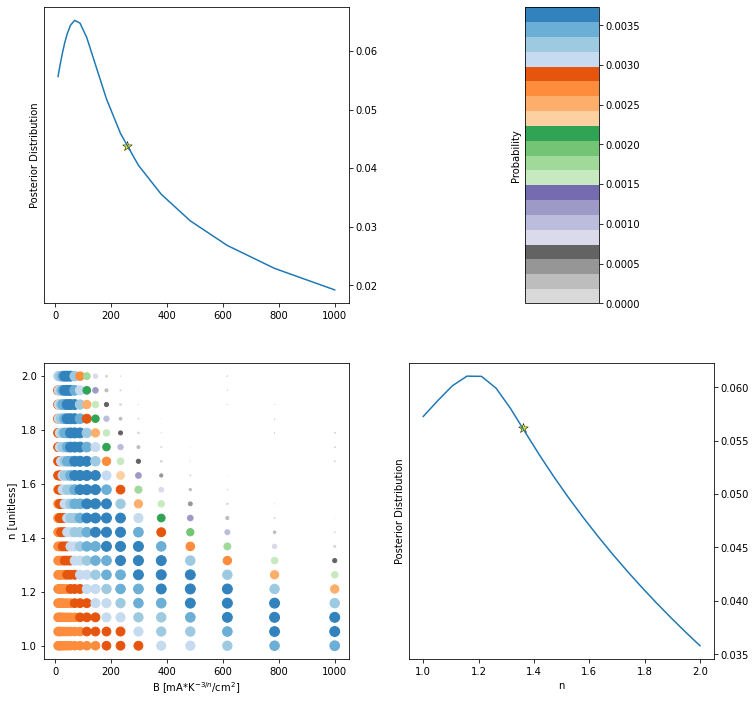

In [ ]:
fig = plt.figure(figsize=(12, 12))

gs = GridSpec(nb_params, nb_params, figure=fig)

# Plot the posterior distribution of each parameter
for i, param_range in enumerate(param_ranges):
  ax = fig.add_subplot(gs[i, i])

  # Optional: set x-axis scale of B to log scale
  # if params[i] == 'Bp':  
  #   ax.set_xscale('log')

  param_post = pd.DataFrame([bpe.xs(param_value, level=params[i])['Posterior'].sum() for param_value in param_range], index=param_range, columns=['Posterior'])
  # check: param_post.sum() = 1 
  param_post.plot(ax=ax, legend=False)

  # Optional: show the true parameter value
  param_post.loc[true_comb[i], 'Posterior']= np.nan
  param_post.interpolate(method='slinear', fill_value='extrapolate', inplace=True)
  ax.scatter(true_comb[i], param_post.loc[true_comb[i], 'Posterior'], s=100, marker='*', c='yellow', linewidths=0.5, edgecolors= 'black')
    
  ax.yaxis.tick_right()
  ax.set_ylabel('Posterior Distribution')
  # ax.set_ylim([0, 1]) #optional 

  if i==nb_params-1:
      ax.set_xlabel(labels[i])

# Plot the relationship between any two parameters x and y (scatterplots)

# This step is needed to normalize the size of the scatterplot dots
vmax = 0.0
for comb in list(itertools.combinations(range(nb_params), 2)):
    x, y = comb[0], comb[1]
    levels = [params[x], params[y]]
    xy_ranges = [param_ranges[x], param_ranges[y]]
    xy_combs = list(itertools.product(*xy_ranges))
    vmax = np.max([vmax, np.max([bpe.xs(xy_comb, level=levels)['Posterior'].sum() for xy_comb in xy_combs])])

# Separate loop to have same vmax in all scatterplots (only 2 parameters -> one scatterplot here)
for comb in list(itertools.combinations(range(nb_params), 2)): 
  x, y = comb[0], comb[1]
  levels = [params[x], params[y]]

  ax = fig.add_subplot(gs[y, x])

  xy_ranges = [param_ranges[x], param_ranges[y]]
  xy_combs = list(itertools.product(*xy_ranges))

  if x==0:
    ax.set_ylabel(f'{labels[y]} [{units[y]}]')
  if y==nb_params-1:
    ax.set_xlabel(f'{labels[x]} [{units[x]}]')

  x = [xy_comb[0] for xy_comb in xy_combs]
  y = [xy_comb[1] for xy_comb in xy_combs]

xy_proba = [bpe.xs(xy_comb, level=levels)['Posterior'].sum() for xy_comb in xy_combs]
sc = ax.scatter(x, y, c=xy_proba, s=[c/vmax*100 for c in xy_proba], cmap='tab20c_r', vmin=0, vmax=vmax)

ax = fig.add_subplot(gs[0, 1], aspect=4)

cmap = matplotlib.cm.tab20c_r

norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cmap, cax=ax)
ax.yaxis.set_label_position('left')
ax.set_ylabel('Probability')
plt.show()

Note that in the scatterplot showing the relationship between the two parameters, both the color and size of a given dot reflect the probability that the corresponding parameter combination (hypothesis) is the true one. As can be seen, there is an inverse relationship between $B$ and $n$, and multiple combinations of these two parameters exist to fit the data.

Also note that the sum of all the probabilities in any given plot is equal to 1.

### Visualize the best fits at different temperatures

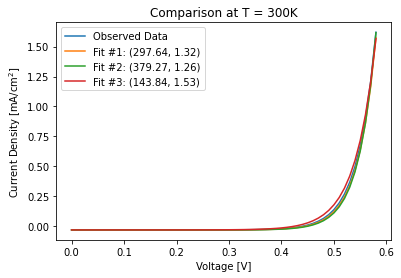

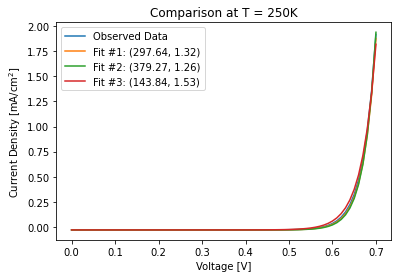

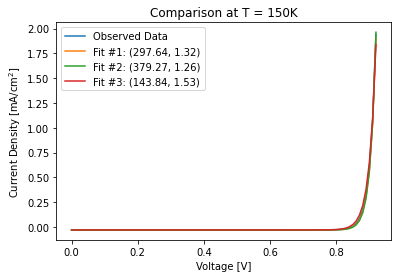

In [ ]:
for T in [300, 250, 150]:
  fig, ax = plt.subplots()

  v_obs = list(data[data['T']==T]['V'])[0]
  j_obs = list(data[data['T']==T]['J'])[0]

  ax.plot(v_obs, j_obs, label=f'Observed Data')

  for i, fit in enumerate(top_fits.index[:3]):
    j_bpe = [compute_ID({'V':v,'T':T}, fit) for v in v_obs]

    ax.plot(v_obs, j_bpe, label=f'Fit #{i+1}: {tuple(map(lambda x:round(x, 2), fit))}')

    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Current Density [mA/cm$^2$]')

  plt.title(f'Comparison at T = {T}K')
  plt.legend()

plt.show()

Below is the solution obtained by the MIT PV-lab benchmark notebook. These results are more accurate because of the additional grid-subdivision and resampling steps (which are not included in this version - not yet at least).

Considering that this code runs much faster, just tune 'param_ranges' and you will get much more accurate results! 

<p align="center">
  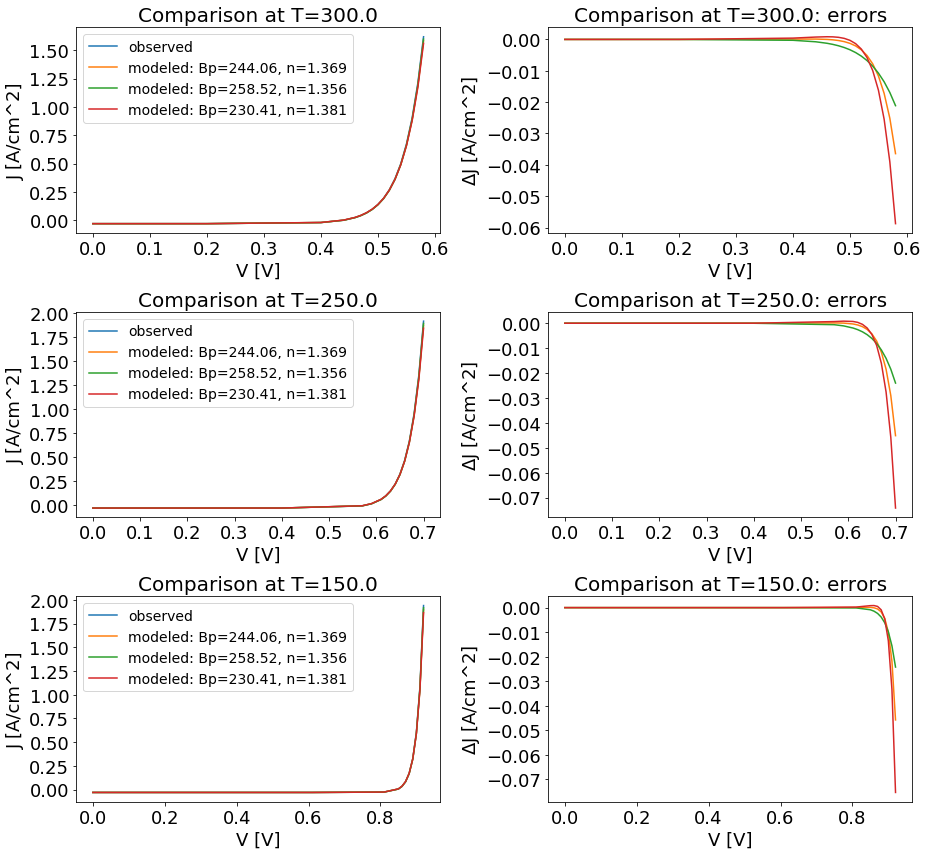
</p>